<a href="https://colab.research.google.com/github/MasahiroAraki/MLCourse/blob/master/06_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第6章

* 線形回帰および正則化
* 回帰木

## 線形回帰

必要なライブラリを読み込みます。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

### データの読み込み

bostonデータは犯罪発生率、部屋数、立地などと不動産価格の関係を示したものです。dataをX、targetをyに格納した後、DESCR属性を表示します。

In [2]:
boston = load_boston()
X = boston.data
y = boston.target
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

np.set_printoptions(suppress=True)  として、ndarrayのデータを表示させたときに指数表示を行わないようにしてから、学習データXの冒頭10件ほどの内容を確認します。

In [3]:
np.set_printoptions(suppress=True)  
X[0:10]

array([[  0.00632,  18.     ,   2.31   ,   0.     ,   0.538  ,   6.575  ,
         65.2    ,   4.09   ,   1.     , 296.     ,  15.3    , 396.9    ,
          4.98   ],
       [  0.02731,   0.     ,   7.07   ,   0.     ,   0.469  ,   6.421  ,
         78.9    ,   4.9671 ,   2.     , 242.     ,  17.8    , 396.9    ,
          9.14   ],
       [  0.02729,   0.     ,   7.07   ,   0.     ,   0.469  ,   7.185  ,
         61.1    ,   4.9671 ,   2.     , 242.     ,  17.8    , 392.83   ,
          4.03   ],
       [  0.03237,   0.     ,   2.18   ,   0.     ,   0.458  ,   6.998  ,
         45.8    ,   6.0622 ,   3.     , 222.     ,  18.7    , 394.63   ,
          2.94   ],
       [  0.06905,   0.     ,   2.18   ,   0.     ,   0.458  ,   7.147  ,
         54.2    ,   6.0622 ,   3.     , 222.     ,  18.7    , 396.9    ,
          5.33   ],
       [  0.02985,   0.     ,   2.18   ,   0.     ,   0.458  ,   6.43   ,
         58.7    ,   6.0622 ,   3.     , 222.     ,  18.7    , 394.12   ,
          5.

In [4]:
y[0:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

組み込みデータセットの特徴名はfeature_names属性の値として文字列配列の形式で得られます。回帰式の解釈に必要になるので確認しておきます。

In [5]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

[LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)で線形回帰関数の学習を行います。

In [6]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

係数と係数の二乗和を表示します。

In [7]:
for f, w in zip(boston.feature_names, lr.coef_) :
    print("{0:7s}: {1:6.2f}". format(f, w))

CRIM   :  -0.11
ZN     :   0.05
INDUS  :   0.02
CHAS   :   2.69
NOX    : -17.77
RM     :   3.81
AGE    :   0.00
DIS    :  -1.48
RAD    :   0.31
TAX    :  -0.01
PTRATIO:  -0.95
B      :   0.01
LSTAT  :  -0.52


In [8]:
sum(lr.coef_**2) #係数の二乗和

340.8546317880219

### 評価

交差確認による[決定係数](http://mathtrain.jp/ketteikeisu)を用いた評価を行います。cross_val_scoreメソッドのscoring引数で決定係数を指定します。scoring引数の可能な値は[こちら](http://scikit-learn.org/stable/modules/model_evaluation.html)。また、交差確認における分割をランダムにするため、[ShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html)を使います。

何度かセルを実行してみると、評価値が変動することがわかります。

In [9]:
cv = ShuffleSplit(n_splits=10)
scores = cross_val_score(lr, X, y, cv=cv, scoring='r2')
print("{0:4.2f} +/- {1:4.2f} ".format(scores.mean(), scores.std()))

0.70 +/- 0.10 


ひとつ抜き方による二乗誤差を用いた評価を行います。ランダム性はないので、分散を求める必要はありません。

In [10]:
cv2 = LeaveOneOut()
scores = cross_val_score(lr, X, y, cv=cv2, scoring='neg_mean_squared_error')
print("{0:4.2f}".format(scores.mean()))

-23.73


## 正則化

[Ridge回帰(L2)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
のパラメータalphaの値でL2正則化項の重みを調整することで、汎化性能が上がる可能性があります。

In [11]:
lr2 = Ridge()
lr2.fit(X, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

係数と係数の二乗和を表示します。

In [12]:
for f, w in zip(boston.feature_names, lr2.coef_) :
    print("{0:7s}: {1:6.2f}". format(f, w))

CRIM   :  -0.10
ZN     :   0.05
INDUS  :  -0.01
CHAS   :   2.55
NOX    : -10.78
RM     :   3.85
AGE    :  -0.01
DIS    :  -1.37
RAD    :   0.29
TAX    :  -0.01
PTRATIO:  -0.88
B      :   0.01
LSTAT  :  -0.53


In [13]:
sum(lr2.coef_**2)

140.54595273340314

交差確認による決定係数を用いた評価

In [14]:
scores = cross_val_score(lr2, X, y, cv=cv, scoring='r2')
print("{0:4.2f} +/- {1:4.2f} ".format(scores.mean(), scores.std()))

0.72 +/- 0.11 


ひとつ抜き方による二乗誤差を用いた評価

In [15]:
scores = cross_val_score(lr2, X, y, cv=cv2, scoring='neg_mean_squared_error')
print("{0:4.2f}".format(scores.mean()))

-23.86


[Lasso回帰(L1)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
のパラメータalphaの値を大きくすれば、L1正則化項の重みが大きくなり、重みが0となる次元が増えます。

In [16]:
lr3 = Lasso(alpha=1.0)
lr3.fit(X, y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

係数と係数の二乗和を表示します。

In [17]:
for f, w in zip(boston.feature_names, lr3.coef_) :
    print("{0:7s}: {1:6.2f}". format(f, w))

CRIM   :  -0.06
ZN     :   0.05
INDUS  :  -0.00
CHAS   :   0.00
NOX    :  -0.00
RM     :   0.95
AGE    :   0.02
DIS    :  -0.67
RAD    :   0.26
TAX    :  -0.02
PTRATIO:  -0.72
B      :   0.01
LSTAT  :  -0.76


In [18]:
sum(lr3.coef_**2)

2.528379232821655

結果に影響の大きい特徴をリストアップ

In [19]:
boston.feature_names[abs(lr3.coef_) > 0.1]

array(['RM', 'DIS', 'RAD', 'PTRATIO', 'LSTAT'], dtype='<U7')

交差確認による決定係数を用いた評価

In [20]:
scores = cross_val_score(lr3, X, y, cv=cv, scoring='r2')
print("{0:4.2f} +/- {1:4.2f} ".format(scores.mean(), scores.std()))

0.64 +/- 0.06 


ひとつ抜き方による二乗誤差を用いた評価

In [21]:
scores = cross_val_score(lr3, X, y, cv=cv2, scoring='neg_mean_squared_error')
print("{0:4.2f}".format(scores.mean()))

-28.41


## 回帰木

回帰木の作成。深さは3にしておきます。

In [22]:
rt = DecisionTreeRegressor(max_depth = 3)
rt.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

木の表示

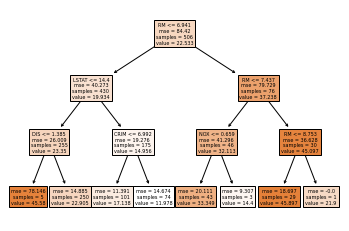

In [23]:
plot_tree(rt, filled=True, feature_names=boston.feature_names)
plt.show()


### 評価

交差確認による決定係数を用いた評価

In [24]:
scores = cross_val_score(rt, X, y, cv=cv, scoring='r2')
print("{0:4.2f} +/- {1:4.2f} ".format(scores.mean(), scores.std()))

0.70 +/- 0.12 


ひとつ抜き方による二乗誤差を用いた評価

In [25]:
scores = cross_val_score(rt, X, y, cv=cv2, scoring='neg_mean_squared_error')
print("{0:4.2f}".format(scores.mean()))

-22.82


### ハイパーパラメータの変更

木を浅くしてみます。

In [26]:
rt2 = DecisionTreeRegressor(max_depth = 2)
rt2.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

木の表示

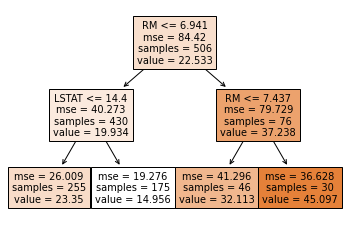

In [27]:
plot_tree(rt2, filled=True, feature_names=boston.feature_names)
plt.show()

交差確認による決定係数を用いた評価

In [28]:
scores = cross_val_score(rt2, X, y, cv=cv, scoring='r2')
print("{0:4.2f} +/- {1:4.2f} ".format(scores.mean(), scores.std()))

0.66 +/- 0.13 


ひとつ抜き方による二乗誤差を用いた評価

In [29]:
scores = cross_val_score(rt2, X, y, cv=cv2, scoring='neg_mean_squared_error')
print("{0:4.2f}".format(scores.mean()))

-28.78


木を深くしてみます。

In [30]:
rt3 = DecisionTreeRegressor(max_depth = 6)
rt3.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

木の表示

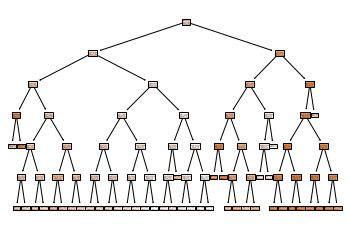

In [31]:
plot_tree(rt3, filled=True, feature_names=boston.feature_names)
plt.show()

交差確認による決定係数を用いた評価

In [32]:
scores = cross_val_score(rt3, X, y, cv=cv, scoring='r2')
print("{0:4.2f} +/- {1:4.2f} ".format(scores.mean(), scores.std()))

0.76 +/- 0.15 


ひとつ抜き方による二乗誤差を用いた評価

In [33]:
scores = cross_val_score(rt3, X, y, cv=cv2, scoring='neg_mean_squared_error')
print("{0:4.2f}".format(scores.mean()))

-20.74


## 課題

scikit-learn付属のdiabetesデータに対して、なるべく性能の高い回帰モデルを求めてください。